In [2]:
!pip install swig
!pip install "gymnasium[all]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.5/989.5 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.3 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 1.4 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 706.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Mountain car

In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Parameters
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.2  # Exploration factor
num_episodes = 500  # Number of episodes for MountainCar

# Initialize the environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
n_states = (10, 10)  # Discretized state space (position, velocity)
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))

# Discretize state space
def discretize_state(state, state_bounds, n_states):
    ratios = [(state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0]) for i in range(len(state))]
    discrete_state = [int(ratio * (n_states[i] - 1)) for i, ratio in enumerate(ratios)]
    discrete_state = np.clip(discrete_state, 0, np.array(n_states) - 1)  # Correct clipping
    return tuple(discrete_state)

# Epsilon-greedy policy
def epsilon_greedy(state, Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(n_actions)  # Explore
    return np.argmax(Q[state])  # Exploit

# Train using SARSA
def train_sarsa():
    Q = np.zeros(n_states + (n_actions,))
    returns = []  # Track returns
    for episode in tqdm(range(num_episodes), desc="SARSA Training"):
        state = discretize_state(env.reset()[0], state_bounds, n_states)
        action = epsilon_greedy(state, Q, epsilon)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, state_bounds, n_states)
            next_action = epsilon_greedy(next_state, Q, epsilon)
            
            # SARSA Update
            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (next_action,)] - Q[state + (action,)])
            
            state, action = next_state, next_action
            total_reward += reward
        
        returns.append(total_reward)
    return Q, returns

# Train using Q-Learning
def train_q_learning():
    Q = np.zeros(n_states + (n_actions,))
    returns = []  # Track returns
    for episode in tqdm(range(num_episodes), desc="Q-Learning Training"):
        state = discretize_state(env.reset()[0], state_bounds, n_states)
        total_reward = 0
        done = False
        
        while not done:
            action = epsilon_greedy(state, Q, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, state_bounds, n_states)
            
            # Q-Learning Update
            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])
            
            state = next_state
            total_reward += reward
        
        returns.append(total_reward)
    return Q, returns

In [5]:
# Train both algorithms
Q_sarsa, returns_sarsa = train_sarsa()
Q_q_learning, returns_q_learning = train_q_learning()

Q-Learning Training: 100%|██████████| 500/500 [00:08<00:00, 55.83it/s] 


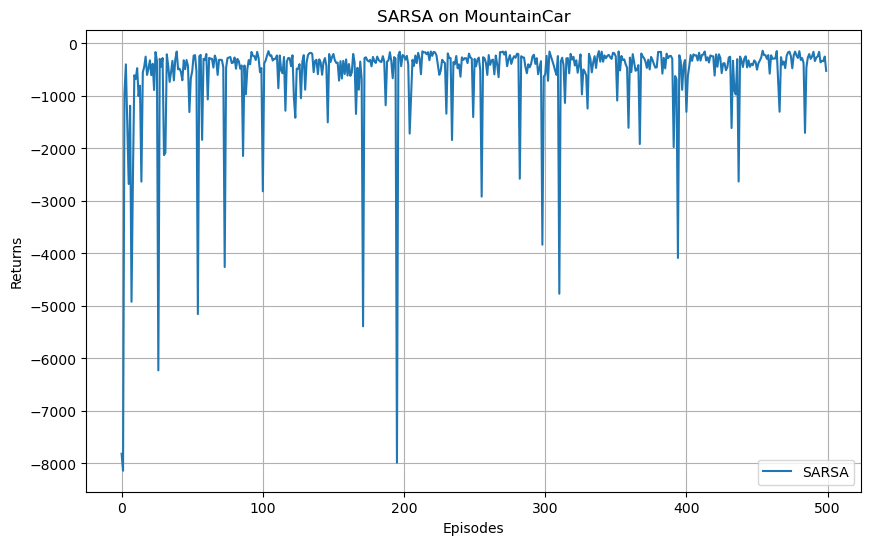

In [6]:
# Plot returns for Sarsa-0
plt.figure(figsize=(10, 6))
plt.plot(returns_sarsa, label="SARSA")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("SARSA on MountainCar")
plt.legend()
plt.grid()
plt.show()

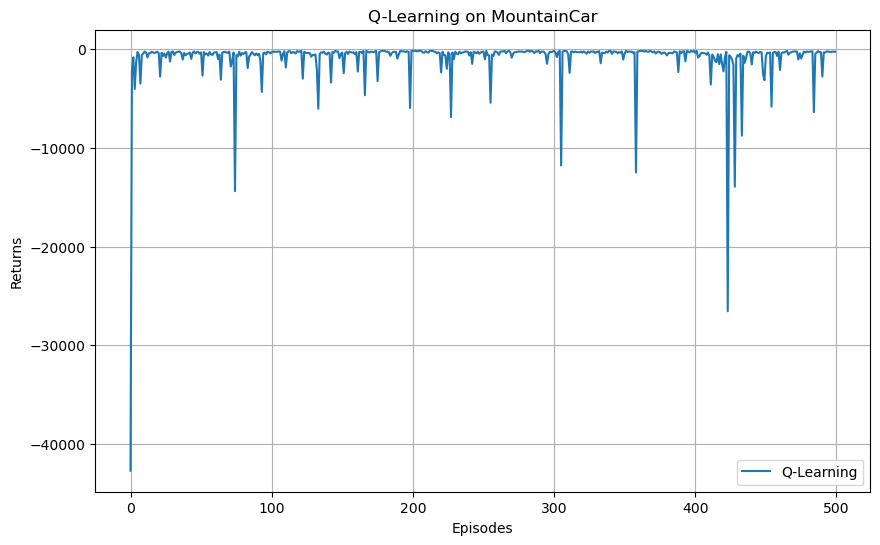

In [7]:
# Plot returns for Q learning
plt.figure(figsize=(10, 6))
plt.plot(returns_q_learning, label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Q-Learning on MountainCar")
plt.legend()
plt.grid()
plt.show()

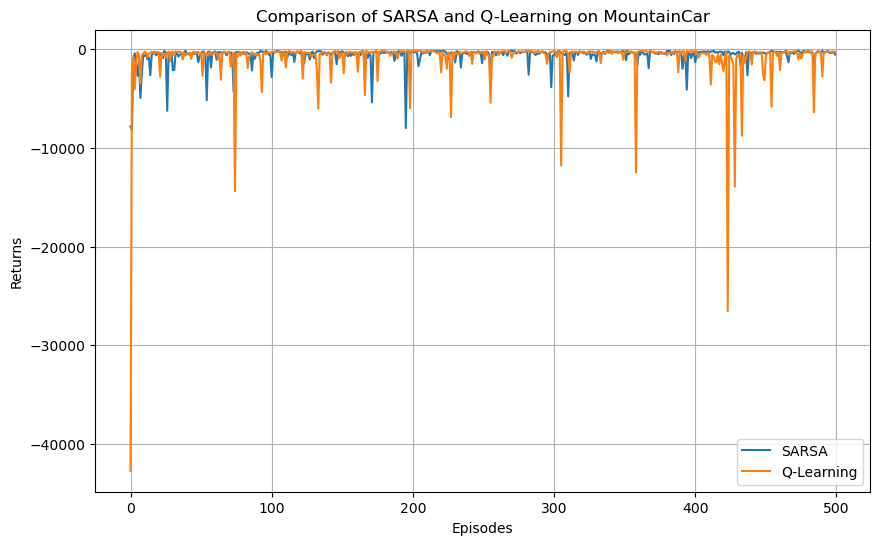

In [8]:
# Plot returns for both algorithms
plt.figure(figsize=(10, 6))
plt.plot(returns_sarsa, label="SARSA")
plt.plot(returns_q_learning, label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Comparison of SARSA and Q-Learning on MountainCar")
plt.legend()
plt.grid()
plt.show()

In [10]:
import time  # For timing execution

def evaluate(Q, max_steps=20000):
    state = discretize_state(env.reset()[0], state_bounds, n_states)
    action = epsilon_greedy(state, Q, 0)  # Exploit-only policy
    done = False
    steps = 0
    start_time = time.time()  # Start timing
    
    while not done and steps < max_steps:
        next_state, _, done, _, _ = env.step(action)
        next_state = discretize_state(next_state, state_bounds, n_states)
        action = epsilon_greedy(next_state, Q, 0)
        steps += 1
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    
    if not done:
        print("The goal was not reached within the step limit.")
    return steps, elapsed_time

In [11]:
# Evaluate the learned strategies
steps_sarsa, time_sarsa = evaluate(Q_sarsa)
steps_q_learning, time_q_learning = evaluate(Q_q_learning)

print(f"Steps to solve using SARSA: {steps_sarsa}, Time taken: {time_sarsa:.4f} seconds")
print(f"Steps to solve using Q-Learning: {steps_q_learning}, Time taken: {time_q_learning:.4f} seconds")


Steps to solve using SARSA: 144, Time taken: 0.0058 seconds
Steps to solve using Q-Learning: 350, Time taken: 0.0124 seconds


## Lunar Lander

In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Parameters
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.2  # Exploration factor
num_episodes = 2000  # Number of episodes for LunarLander
lambda_val = 0.8  # SARSA(λ) decay parameter

# Initialize environment
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
n_states = tuple((10, 10, 10, 10, 10, 10, 2, 2))  # Discretized state space
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[-2] = (-0.5, 0.5)  # Angle correction
state_bounds[-1] = (-0.5, 0.5)  # Angular velocity correction

# Discretize state space
def discretize_state(state, state_bounds, n_states):
    ratios = [(state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0]) for i in range(len(state))]
    discrete_state = [int(ratio * (n_states[i] - 1)) for i, ratio in enumerate(ratios)]
    discrete_state = np.clip(discrete_state, 0, np.array(n_states) - 1)
    return tuple(discrete_state)

# Epsilon-greedy policy
def epsilon_greedy(state, Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(n_actions)  # Explore
    return np.argmax(Q[state])  # Exploit

# Evaluate policy
def evaluate(Q, max_steps=1000):
    state = discretize_state(env.reset()[0], state_bounds, n_states)
    action = epsilon_greedy(state, Q, 0)  # Exploit-only policy
    done = False
    steps = 0
    total_reward = 0
    start_time = time.time()

    while not done and steps < max_steps:
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        next_state = discretize_state(next_state, state_bounds, n_states)
        action = epsilon_greedy(next_state, Q, 0)
        steps += 1

    elapsed_time = time.time() - start_time
    return steps, total_reward, elapsed_time

# SARSA(0) Algorithm
def sarsa_0():
    Q = np.zeros(n_states + (n_actions,))
    returns = []
    for episode in tqdm(range(num_episodes), desc="SARSA(0)"):
        state = discretize_state(env.reset()[0], state_bounds, n_states)
        action = epsilon_greedy(state, Q, epsilon)
        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, state_bounds, n_states)
            next_action = epsilon_greedy(next_state, Q, epsilon)

            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (next_action,)] - Q[state + (action,)])

            state, action = next_state, next_action
            total_reward += reward

        returns.append(total_reward)

    return Q, returns

# Q-Learning Algorithm
def q_learning():
    Q = np.zeros(n_states + (n_actions,))
    returns = []
    for episode in tqdm(range(num_episodes), desc="Q-Learning"):
        state = discretize_state(env.reset()[0], state_bounds, n_states)
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(state, Q, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, state_bounds, n_states)

            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])

            state = next_state
            total_reward += reward

        returns.append(total_reward)

    return Q, returns

# SARSA(λ) Algorithm
def sarsa_lambda(lambda_val=0.8):
    Q = np.zeros(n_states + (n_actions,))
    returns = []
    for episode in tqdm(range(num_episodes), desc="SARSA(λ)"):
        state = discretize_state(env.reset()[0], state_bounds, n_states)
        action = epsilon_greedy(state, Q, epsilon)
        total_reward = 0
        done = False
        E = np.zeros_like(Q)  # Eligibility trace

        cur_step = 0
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, state_bounds, n_states)
            next_action = epsilon_greedy(next_state, Q, epsilon)

            delta = reward + gamma * Q[next_state + (next_action,)] - Q[state + (action,)]
            E[state + (action,)] += 1  # Update eligibility trace

            # Update Q-values and decay eligibility traces
            Q += alpha * delta * E
            E *= gamma * lambda_val

            state, action = next_state, next_action
            total_reward += reward

            cur_step += 1
            if cur_step > 20:
              break

        returns.append(total_reward)

    return Q, returns

# Train and compare algorithms
Q_sarsa, returns_sarsa = sarsa_0()
Q_q_learning, returns_q_learning = q_learning()
Q_sarsa_lambda, returns_sarsa_lambda = sarsa_lambda(lambda_val)

SARSA(λ): 100%|██████████| 2000/2000 [15:06<00:00,  2.21it/s]


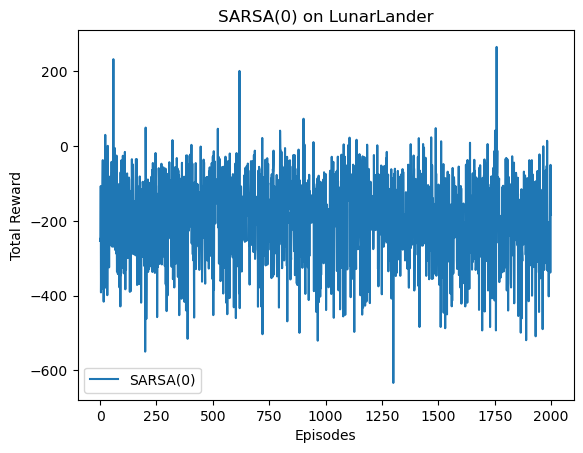

In [6]:
# Plot performance sarsa 0
plt.plot(returns_sarsa, label="SARSA(0)")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("SARSA(0) on LunarLander")
plt.legend()
plt.show()

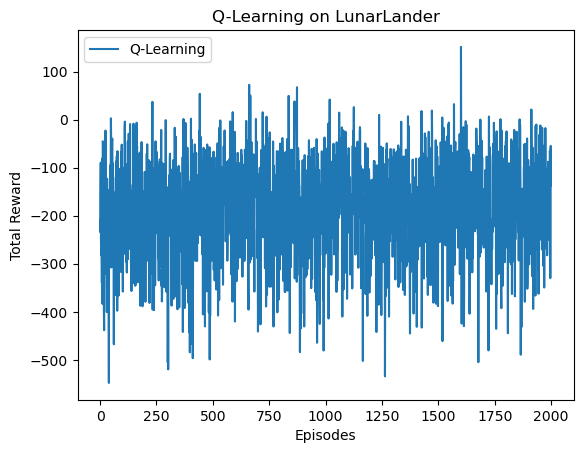

In [7]:
# Plot performance q learning
plt.plot(returns_q_learning, label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning on LunarLander")
plt.legend()
plt.show()

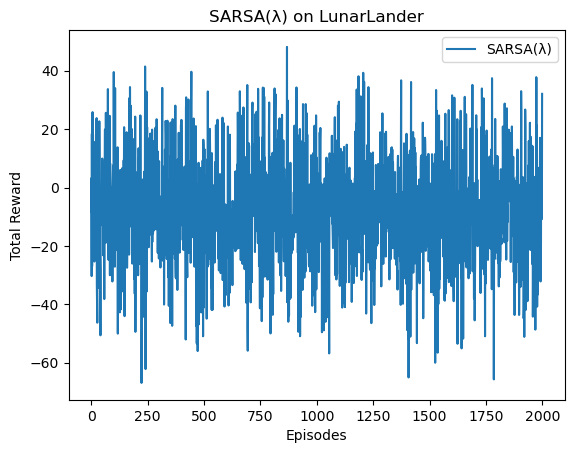

In [8]:
# Plot performance sarsa lambda
plt.plot(returns_sarsa_lambda, label="SARSA(λ)")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) on LunarLander")
plt.legend()
plt.show()

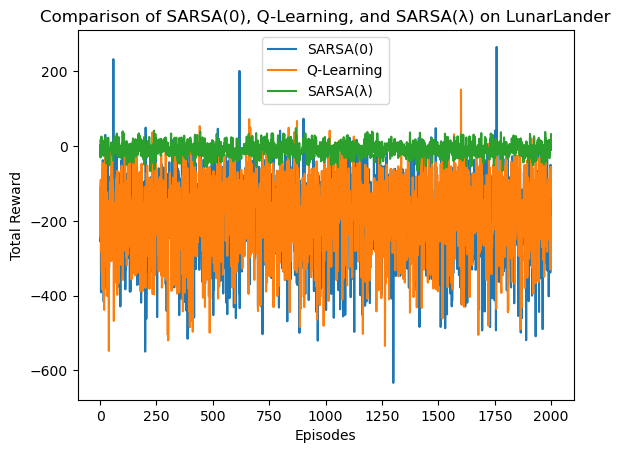

In [9]:
# Plot performance
plt.plot(returns_sarsa, label="SARSA(0)")
plt.plot(returns_q_learning, label="Q-Learning")
plt.plot(returns_sarsa_lambda, label="SARSA(λ)")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Comparison of SARSA(0), Q-Learning, and SARSA(λ) on LunarLander")
plt.legend()
plt.show()

In [12]:
# Evaluate the learned policies
steps_sarsa, reward_sarsa, time_sarsa = evaluate(Q_sarsa)
steps_q_learning, reward_q_learning, time_q_learning = evaluate(Q_q_learning)
steps_sarsa_lambda, reward_sarsa_lambda, time_sarsa_lambda = evaluate(Q_sarsa_lambda)

print(f"SARSA(0): Steps={steps_sarsa}, Reward={reward_sarsa:.2f}, Time={time_sarsa:.4f} seconds")
print(f"Q-Learning: Steps={steps_q_learning}, Reward={reward_q_learning:.2f}, Time={time_q_learning:.4f} seconds")
print(f"SARSA(λ): Steps={steps_sarsa_lambda}, Reward={reward_sarsa_lambda:.2f}, Time={time_sarsa_lambda:.4f} seconds")

SARSA(0): Steps=152, Reward=-591.52, Time=0.0126 seconds
Q-Learning: Steps=63, Reward=-429.39, Time=0.0043 seconds
SARSA(λ): Steps=111, Reward=-222.79, Time=0.0059 seconds
